<div align="center">
<a href="https://vbti.nl"><img src="./vbti_logo.png" width="400"></a>
</div>

# IMBD - Deep Learning

In this notebook we continue with the IMDB dataset and start building deep learning models to predict the movie score.

It contains the following sections:
 1. Converting the reviews to word embeddings, again, with the `Word2Vec` class.
 2. We will build, train and evaluate three different architectures:
  - A Multilayer perceptron, this is (as discussed in the masterclass) the most basic neural network.
  - A 1D dimensional convolutional neural network (CNN).
  - A simple recurrent neural network.
  - A LSTM.
  - A bidirectional LSTM.
    
    Al these networks are build with the package `keras`.

In [2]:
# load some common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# read pickle files
import pickle

filename = './train_data.pickle'
with open(filename, 'rb') as file_object:
    train_data = pickle.load(file_object)
    
filename = './test_data.pickle'
with open(filename, 'rb') as file_object:
    test_data = pickle.load(file_object)    

# Word2vec

In [4]:
# prepare data for gensim
# data needs to be presented as a list of list of words
sentences = []
for review in train_data[0]:
    sentences.append(review.split(' '))

In [5]:
# vector-space embedding
n_embed_dim = 128
n_context = 3

# (maximum) size of review as input for deep nn model
n_input_dim = 100

In [6]:
from gensim.models.word2vec import Word2Vec

model_w2v = Word2Vec(sentences, size=n_embed_dim, window=n_context, min_count=10, workers=4)
model_w2v.init_sims(replace=True)

In [7]:
def featurize_w2v_dl(model_w2v, sentences, n_input_dim, n_embed_dim):
    n_train_samples = len(sentences)
    wv = np.zeros((n_train_samples, n_input_dim, n_embed_dim))

    for i in range(n_train_samples):
        sentence = sentences[i]
        n_words = len(sentence)

        if n_words > n_input_dim:
            for j, w in enumerate(sentence[0:n_input_dim]):
                try:
                    vec = model_w2v.wv[w]
                    wv[i,j,:] = vec
                except KeyError:
                    continue
        else:
            start = (n_input_dim - n_words) // 2
            for j, w in enumerate(sentence[0:n_input_dim]):
                try:
                    vec = model_w2v.wv[w]
                    wv[i,start+j,:] = vec
                except KeyError:
                    continue
    return wv

In [8]:
X_train = featurize_w2v_dl(model_w2v, sentences, n_input_dim, n_embed_dim)
y_train = np.array(train_data[1])

In [9]:
X_train.shape

(25000, 100, 128)

In [10]:
sentences = []
for review in test_data[0]:
    sentences.append(review.split(' '))
X_test = featurize_w2v_dl(model_w2v, sentences, n_input_dim, n_embed_dim)
y_test = np.array(test_data[1])

# Model building

Define some handy utility functions to plot model performance.

In [11]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          ax=None,
                          figsize=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax==None:
        _, ax = plt.subplot(1, 1, figsize=figsize)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, pad=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.tick_params(axis='x', rotation=90)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, 
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')    
    ax.set_ylim((len(classes) - 0.5, -0.5))

    
def accuracy(y, y_pred):
    return np.sum(y==y_pred)/len(y)


def plot_model_performance(model, X_train, y_train, X_test, y_test, label_names, figsize=(8,6)):
    """Support function for quickly plotting model performance."""
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs.ravel()

    y_train_pred = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    plot_confusion_matrix(cm_train, 
                          list(label_names), 
                          title='Training - accuracy: {:.2f}'.format(accuracy(y_train, y_train_pred)),
                          ax=axs[0])

    y_test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    plot_confusion_matrix(cm_test, 
                          list(label_names), 
                          title='Test - accuracy: {:.2f}'.format(accuracy(y_test, y_test_pred)),
                          ax=axs[1])

    plt.tight_layout()    

## Multi Layer Perceptron

In [13]:
# # select GPU on VBTI server
# import os
# GPU = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = GPU

In [12]:
!pip install tensorflow

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 421.8 MB 73.5 MB/s eta 0:00:01  |▌                               | 6.5 MB 3.1 MB/s eta 0:02:1509                       | 40.3 MB 47.7 MB/s eta 0:00:09     |████                            | 51.7 MB 47.7 MB/s eta 0:00:08     |██████████                      | 131.5 MB 72.9 MB/s eta 0:00:04     |██████████▏                     | 134.1 MB 72.9 MB/s eta 0:00:04     |███████████████▌                | 203.8 MB 50.0 MB/s eta 0:00:05

In [13]:
!pip install keras

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [12]:
import tensorflow
import keras

n_dense = 256
dropout = 0.2

batch_size = 64
epochs = 10

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=(n_input_dim, n_embed_dim)))
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 47s 2ms/step - loss: 0.4664 - accuracy: 0.7784 - val_loss: 0.4392 - val_accuracy: 0.7926
Epoch 2/10
25000/25000 [==============================] - 43s 2ms/step - loss: 0.3559 - accuracy: 0.8409 - val_loss: 0.4363 - val_accuracy: 0.7984
Epoch 3/10
25000/25000 [==============================] - 44s 2ms/step - loss: 0.2700 - accuracy: 0.8846 - val_loss: 0.4700 - val_accuracy: 0.7922
Epoch 4/10
25000/25000 [==============================] - 43s 2ms/step - loss: 0.1621 - accuracy: 0.9437 - val_loss: 0.5325 - val_accuracy: 0.7872
Epoch 5/10
25000/25000 [==============================] - 44s 2ms/step - loss: 0.0660 - accuracy: 0.9838 - val_loss: 0.6297 - val_accuracy: 0.7791
Epoch 6/10
25000/25000 [==============================] - 43s 2ms/step - loss: 0.0258 - accuracy: 0.9961 - val_loss: 0.7346 - val_accuracy: 0.7870
Epoch 7/10
25000/25000 [==============================] - 44s 2ms/st

ValueError: Classification metrics can't handle a mix of binary and continuous targets

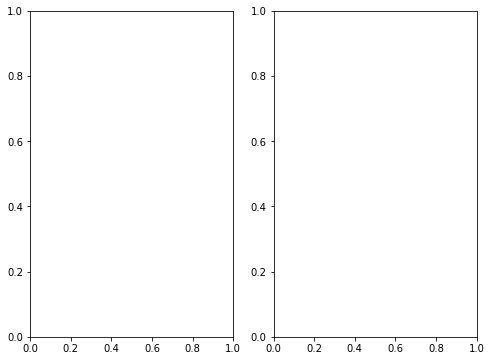

In [16]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

# 1D Convolutional Neural Network

In [ ]:
n_kernels = 256
kernel_size = 3

n_dense = 256
dropout = 0.2

batch_size = 64
epochs = 10

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Conv1D(n_kernels, kernel_size, activation='relu', input_shape=(n_input_dim, n_embed_dim)))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

In [ ]:
x = featurize_w2v_dl(model_w2v, ['nice movie and i really liked the end'.split()], n_input_dim, n_embed_dim)
model.predict(x)

In [ ]:
x = featurize_w2v_dl(model_w2v, ['this was a waste of time a terrible movie'.split()], n_input_dim, n_embed_dim)
model.predict(x)

In [ ]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

# Recurrent Neural Networks

## Simple RNN

In [ ]:
# parameters
epochs = 10
batch_size = 128

n_rnn = 256
drop_rnn = 0.2

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

model = Sequential()

model.add(SimpleRNN(n_rnn, dropout=drop_rnn, activation='relu', input_shape=(None, n_embed_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

In [ ]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

## Long Short Term Memory

In [ ]:
# parameters
epochs = 10
batch_size = 128

n_lstm = 256
drop_lstm = 0.2

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

model = Sequential()

model.add(LSTM(n_lstm, dropout=drop_lstm, activation='relu', input_shape=(None, n_embed_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(X_test, y_test))

In [ ]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])

## Bidirectional LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers.wrappers import Bidirectional

model = Sequential()

model.add(Bidirectional(LSTM(n_rnn, dropout=drop_rnn, activation='relu'), input_shape=(None, n_embed_dim)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

In [ ]:
plot_model_performance(model, X_train, y_train, X_test, y_test, ['negative', 'positive'])